In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip
```
We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not.

### Dataset preparation
For the rest of the homework, you'll need to use only these columns:
```
'age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y'
```
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [2]:
file = "../3_classification/data/bank-full.csv"
columns = ['age','job','marital','education','balance','housing','contact',
           'day','month','duration','campaign','pdays','previous','poutcome','y']

In [3]:
df = pd.read_csv(file, delimiter=";", usecols=columns)

In [4]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
seed = 1
df_full_train, df_test = train_test_split(df, random_state=seed, test_size=0.2)
df_train, df_val = train_test_split(df_full_train, random_state=seed, test_size=0.25)
assert df.shape[0] == df_train.shape[0] + df_val.shape[0] + df_test.shape[0]

### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.

Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* `balance`
* `day`
* `duration`
* `previous`

In [6]:
num_cols = list(df_train.select_dtypes(include='number').columns)
num_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [7]:
auc_score = {n: roc_auc_score(df_train['y'], df_train[n]) for n in num_cols}
print(sorted(auc_score.items(), key=lambda x:x[1], reverse=True))

[('duration', 0.8147002759670778), ('previous', 0.5985653242764153), ('pdays', 0.5901276247352144), ('balance', 0.5888313805382317), ('age', 0.48781428247265596), ('day', 0.474042117616092), ('campaign', 0.42854569843178414)]


### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.69
* 0.79
* 0.89
* 0.99

In [8]:
def get_X_y(df, target):
    X = df.drop([target], axis=1).copy()
    y = df[target].copy()
    
    return X,y

In [9]:
def get_model(C=1.0):
    return LogisticRegression(solver='liblinear', C=C, max_iter=1000)

In [10]:
# Apply one-hot-encoding using DictVectorizer and train the logistic regression
X_train, y_train = get_X_y(df_train, 'y')
X_val, y_val = get_X_y(df_val, 'y')

dv = DictVectorizer()
X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))

model = get_model()
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [11]:
y_pred = model.predict_proba(X_val)[:,1]
round(roc_auc_score(y_val, y_pred), 3)

0.9

### Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

For each threshold, compute precision and recall

Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

In [12]:
def get_precision_recall(X, y, model, threshold):
    actual_positive = (y == 'yes')
    actual_negative = (y == 'no')
    
    pred = model.predict_proba(X)[:,1]
    pred_positive = pred >= threshold
    pred_negative = pred < threshold

    tp = (pred_positive & actual_positive).sum()
    tn = (pred_negative & actual_negative).sum()
    
    fp = (pred_positive & actual_negative).sum()
    fn = (pred_negative & actual_positive).sum()

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return precision, recall

In [13]:
thresholds = np.linspace(0.0, 1.0, 101)
precision = []
recall = []
for t in thresholds:
    p, r = get_precision_recall(X_val, y_val, model, t)
    precision.append(p)
    recall.append(r)

/var/folders/k5/_r7c2p9n4l7c8mj8yt2hzxgr0000gn/T/ipykernel_47058/1132537793.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


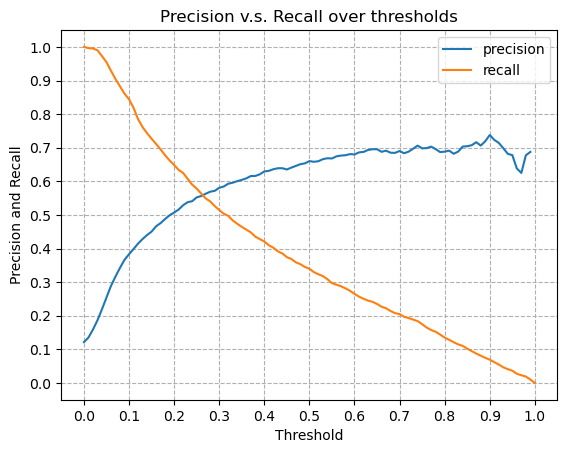

In [14]:
title = "Precision v.s. Recall over thresholds"
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel("Threshold")
plt.ylabel("Precision and Recall")
plt.title(title)
plt.legend()
plt.grid(linestyle="--")
plt.show()

### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F1=2⋅\frac{P⋅R}{P+R}$$
Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.02
* 0.22
* 0.42
* 0.62

In [15]:
assert len(precision) == len(recall)
f1 = [(2* precision[i] * recall[i]) / (precision[i] + recall[i]) for i in range(len(precision))]
threshold_f1 = dict(zip(thresholds, f1))
for t in [0.02, 0.22, 0.42, 0.62]:
    print(f"Threshold {t}, F1 = {threshold_f1[t]}")

Threshold 0.02, F1 = 0.2739691690688056
Threshold 0.22, F1 = 0.5728601252609603
Threshold 0.42, F1 = 0.4930284439486894
Threshold 0.62, F1 = 0.36715620827770357


### Question 5: 5-Fold CV
Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

* 0.0001
* 0.006
* 0.06
* 0.26

In [16]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [17]:
def get_auc(train_idx, val_idx, C=1.0):
    X_train, y_train = get_X_y(df_full_train.iloc[train_idx], 'y')
    X_val, y_val = get_X_y(df_full_train.iloc[val_idx], 'y')
    
    dv = DictVectorizer()
    X_train = dv.fit_transform(X_train.to_dict(orient='records'))
    X_val = dv.transform(X_val.to_dict(orient='records'))
    
    model = get_model(C)
    print(model.get_params())
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:,1]
    return roc_auc_score(y_val, y_pred)

In [18]:
scores = [get_auc(train_idx, val_idx) for train_idx, val_idx in kfold.split(df_full_train)]
print(f"Standard deviation of KFold AUC scores: {np.std(scores)}")    

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'mult

### Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter `C`

Iterate over the following `C` values: `[0.000001, 0.001, 1]`

Initialize `KFold` with the same parameters as previously

Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`

Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

* 0.000001
* 0.001
* 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [19]:
means = {}
for C in [0.000001, 0.001, 1]:
    scores = [get_auc(train_idx, val_idx, C) for train_idx, val_idx in kfold.split(df_full_train)]
    means[C] = (round(np.mean(scores), 3), round(np.std(scores), 3))

{'C': 1e-06, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 1e-06, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 1e-06, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'C': 1e-06, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100

Best mean score for AUC would indicate the **largest mean AUC**, since we want a large Area under the Curve for our model.

In [20]:
# Sort by largest mean in the (mean, std dev) tuple
print(sorted(means.items(), key=lambda x:x[1][0], reverse=True))

[(1, (0.906, 0.006)), (0.001, (0.861, 0.007)), (1e-06, (0.701, 0.009))]
